# Part II - Pyro Inference

We have already covered:

 - Pyro primitives - `pyro.param`, `pyro.sample`.
 - Effect handlers - `poutine.replay`, `poutine.trace`.
 - Pyro models and guides.
 
In this section, we will learn about *automatic inference* in Pyro, and how to use Pyro primitives and the effect handling library (`pyro.poutine`) to build custom tools for analysis.

In [83]:
%reset -sf

from collections import defaultdict

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
import pyro.optim as optim
import pyro.poutine as poutine
import seaborn as sns
import torch
from torch.distributions import constraints

%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 6)

print('pyro ver: {}'.format(pyro.__version__))
print('pytorch ver: {}'.format(torch.__version__))

plt.rcParams.update({'font.size': 16,
                     'xtick.labelsize': 14,
                     'ytick.labelsize': 14,
                     'axes.titlesize': 'large', 
                     'axes.labelsize': 'medium'})

pyro ver: 0.4.0
pytorch ver: 1.2.0


## Problem Domain

We are provided with a time series dataset of the number of initial unemployment insurance claims for all of U.S. from the Department of Labor (https://oui.doleta.gov/unemploy/claims.asp).

In this notebook, we will use this dataset to:
 - build a regression model using Pyro to model the global trend and seasonality.
 - build a model to forecast unemployment claims over extended time horizon, and infer model parameters using:
   - MAP inference.
   - Variational inference using different guide families.
   - Markov Chain Monte Carlo with a No-U-Turn Sampler (NUTS).

In [84]:
unemployment = pd.read_csv('data/unemployment_claims.csv')
unemployment['date'] = pd.to_datetime(unemployment['date'])
unemployment.head()

,date,initial claim
0,2010-01-02,651215
1,2010-01-09,825891
2,2010-01-16,659173
3,2010-01-23,507651
4,2010-01-30,538617


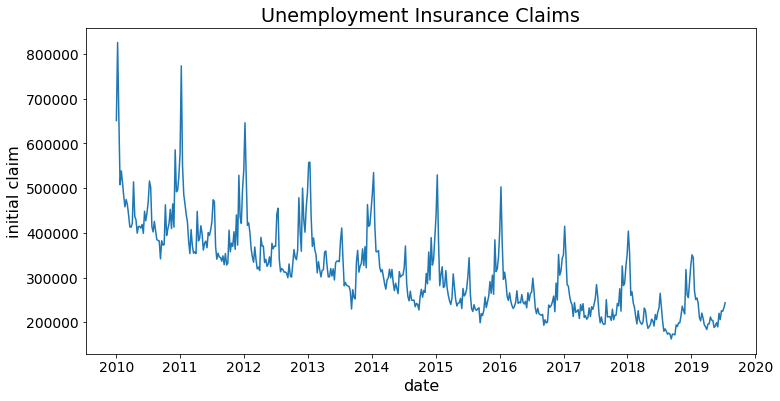

In [85]:
y = torch.tensor(unemployment['initial claim'].values, dtype=torch.float32)
sns.lineplot(x='date', y='initial claim', data=unemployment).set_title('Unemployment Insurance Claims');

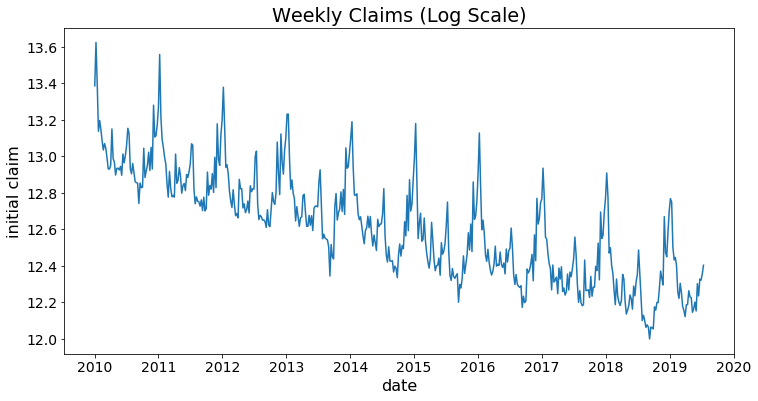

In [86]:
init_date = '2010-01-02'
time_range = pd.date_range(start=init_date, freq='7D', periods=len(y))
y_log = y.log()
fig, ax = plt.subplots()
ax.plot(time_range, y_log)
ax.set(title='Weekly Claims (Log Scale)', xlabel='date', ylabel='initial claim');

## Model specification in Pyro

### Fitting a Regression Model

Let us first try to fit a regression model of the form:

$$
\begin{align*}
ln(y_i) &\sim \mathcal{N}(\mu_i, \sigma)\\
\mu_i &= slope\ .\ t_i + intercept \\
\end{align*}
$$

For simplicity, let us assume that $\sigma = 1$ to begin with.

In [87]:
def model_global_trend(y):
    slope = pyro.param('slope', torch.tensor(1.))
    intercept = pyro.param('intercept', torch.tensor(13.))
    for i in range(len(y)):
        log_y_hat = slope * i + intercept
        pyro.sample('y_{}'.format(i), dist.LogNormal(log_y_hat, 1.), obs=y[i])

This model code is mostly just a translation of our data generating process.
 - By using `pyro.param`, we are designating model parameters that we would like to optimize.
 - Note that the observations are denoted by the `obs=` keyword argument to `pyro.sample`. This specifies the likelihood function.
 - Modeling is *distinct* from inference.


### Vectorized model using `pyro.plate`
    
Tensor libraries like PyTorch have highly optimized linear algebra routines that can exploit data parallelism. Let us vectorize the *likelihood* computation to operate over all data in parallel.

In [88]:
def model_global_trend(y):
    slope = pyro.param('slope', torch.tensor(1.))
    intercept = pyro.param('intercept', torch.tensor(13.))
    with pyro.plate('N', len(y)) as t:                        
        log_y_hat = slope * t.type(torch.float) + intercept
        pyro.sample('y', dist.LogNormal(log_y_hat, 1.), obs=y)

**Test-Train Split**: Reserve the last 100 data-points for testing.

In [89]:
N = len(y)
N_test = 100
N_train = N - N_test
y_train = y[:-N_test]

### Fitting a Maximum Likelihood model to the data

 - We pass an empty guide `lambda x: None` since the model does not have any latent parameter.
 - The loss function is given by `Trace_ELBO`. With an empty guide and only `pyro.param` statements in the model, this simply computes the NLL `- log(p(y|x))`. We minimize this using the Adam optimizer.

In [90]:
%%time

opt = optim.Adam({'lr': 0.08})
pyro.clear_param_store()
pyro.set_rng_seed(1)
empty_guide = lambda x: None
svi = SVI(model_global_trend, empty_guide, opt, loss=Trace_ELBO())

for i in range(1600):
    loss = svi.step(y_train)
    if i % 100 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 26399.26381909548
ELBO loss: 14.252707629946608
ELBO loss: 13.745012906328517
ELBO loss: 13.729082423837939
ELBO loss: 13.712590049858669
ELBO loss: 13.696713548209798
ELBO loss: 13.682234414258794
ELBO loss: 13.669615165672111
ELBO loss: 13.659033693859925
ELBO loss: 13.65048509147299
ELBO loss: 13.643809869660805
ELBO loss: 13.638776156171483
ELBO loss: 13.635107912609925
ELBO loss: 13.632519285882537
ELBO loss: 13.630751413316583
ELBO loss: 13.629593278894472
ELBO loss: 13.628859630182161
CPU times: user 1.15 s, sys: 23.4 ms, total: 1.17 s
Wall time: 1.17 s


### Plotting the regression fit

In [91]:
slope = pyro.param('slope').detach()
intercept = pyro.param('intercept').detach()

slope, intercept

(tensor(-0.0015), tensor(12.9615))

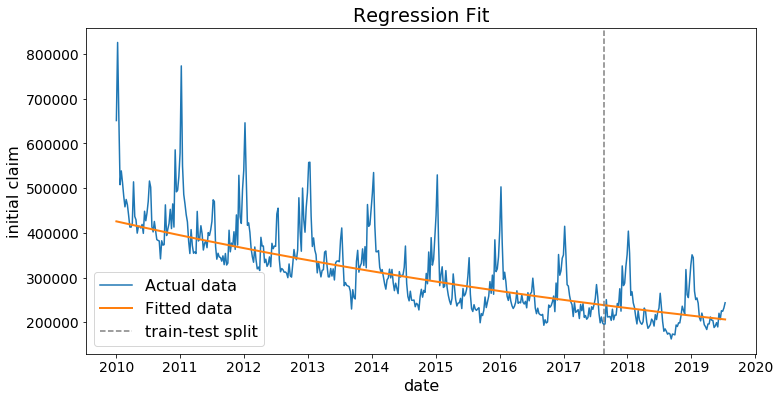

In [92]:
model_fit = (slope * torch.arange(len(y)).type(torch.float) + intercept).exp()

fig, ax = plt.subplots()
ax.plot(time_range, y, label='Actual data')
ax.plot(time_range, model_fit.detach(), linewidth=2, label='Fitted data')
ax.axvline(time_range[N_train], linestyle='--', color='gray', label='train-test split')
ax.set(title='Regression Fit', xlabel='date', ylabel='initial claim')
plt.legend();

### Fitting a Seasonal Component + Global Trend

The unemployment claims dataset exhibits a strong seasonality component. Let us plot the time series for the first two years overlaid.

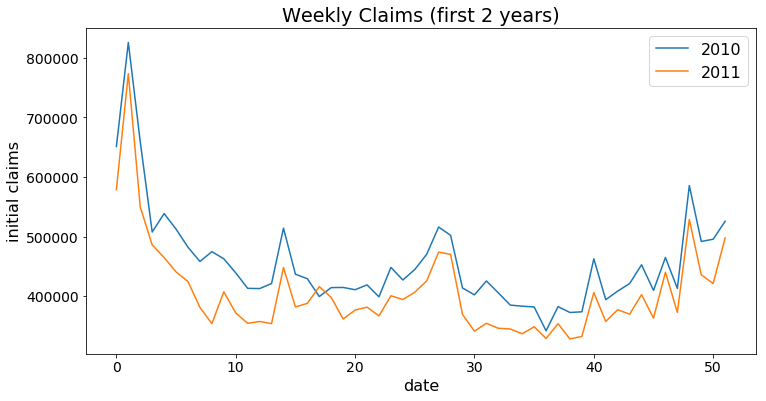

In [93]:
fig, ax = plt.subplots()
ax.plot(np.arange(52), y[:52], label='2010');
ax.plot(np.arange(52), y[52:104], label='2011');
plt.legend()
ax.set(title='Weekly Claims (first 2 years)', xlabel='date', ylabel='initial claims');

### A Sesonal Global Trend (SGT) Model

 - In addition to the *global trend*, this includes a cyclic seasonality intercept. 
 - We will use `SVI` to fit this model in a similar fashion. 

In [94]:
def model_sgt(y):    
    slope = pyro.param('slope', torch.tensor(1.))
    intercept = pyro.param('intercept', torch.tensor(13.))
    seasonality = pyro.param('seasonality', torch.zeros(52))
    seasonality = seasonality - seasonality.mean()
    N = len(y)
    with pyro.plate('N', N) as t:
        seasonality_factor = seasonality.repeat(math.ceil(N / 52))[:N]
        log_y_hat = slope * t.type(torch.float) + intercept + seasonality_factor
        pyro.sample('y', dist.LogNormal(log_y_hat, 1.), obs=y)

In [95]:
%%time

opt = optim.Adam({'lr': 0.08})
pyro.clear_param_store()
pyro.set_rng_seed(1)
empty_guide = lambda x: None
svi = SVI(model_sgt, empty_guide, opt, loss=Trace_ELBO())

for i in range(3000):
    loss = svi.step(y_train)
    if i % 500 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))        

ELBO loss: 26399.26381909548
ELBO loss: 13.683769187735553
ELBO loss: 13.631697304883794
ELBO loss: 13.61758131477701
ELBO loss: 13.615883371937814
ELBO loss: 13.615797493326005
ELBO loss: 13.615795039651381
CPU times: user 2.55 s, sys: 39.1 ms, total: 2.59 s
Wall time: 2.59 s


In [96]:
slope = pyro.param('slope').detach()
intercept = pyro.param('intercept').detach()

slope, intercept

(tensor(-0.0018), tensor(13.0455))

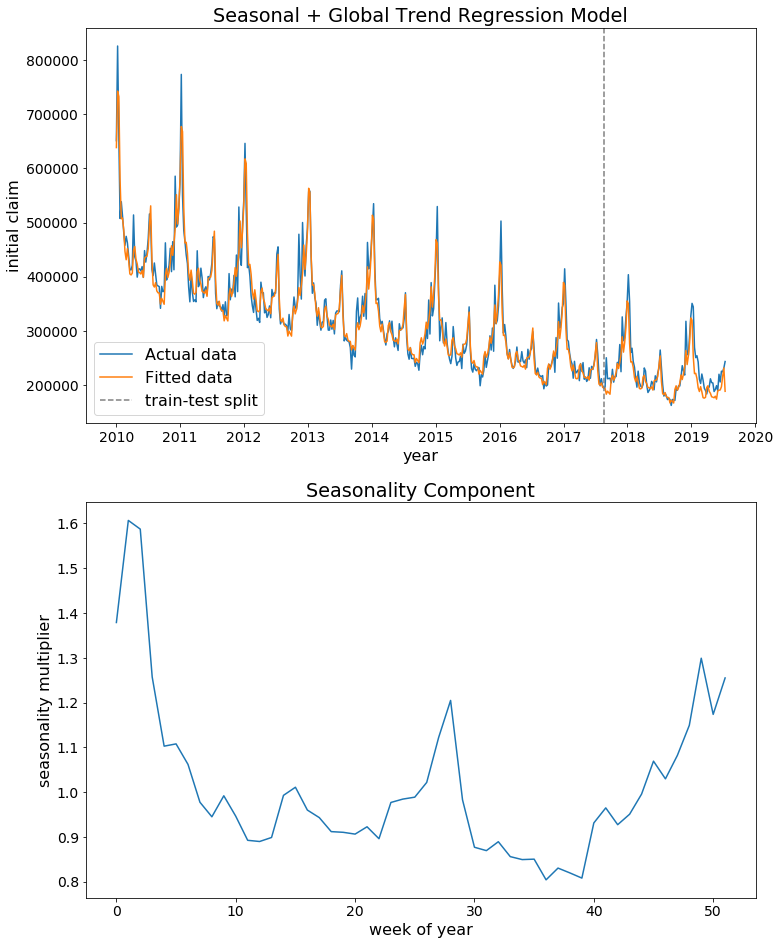

In [97]:
slope = pyro.param('slope').detach()
intercept = pyro.param('intercept').detach()
seasonality = pyro.param('seasonality').detach()
seasonality = (seasonality - seasonality.mean())
seasonality_rep = seasonality.repeat(math.ceil(len(y) / 52))[:len(y)]
model_fit = (slope * torch.arange(len(y)).type(torch.float) + intercept + seasonality_rep).exp()

fig, ax = plt.subplots(2, 1, figsize=(12, 16))
ax[0].plot(time_range, y, label='Actual data')
ax[0].plot(time_range, model_fit.detach(), label='Fitted data')
ax[0].set(title='Seasonal + Global Trend Regression Model', 
          xlabel='year', 
          ylabel='initial claim')
ax[0].axvline(time_range[N_train], linestyle='--', color='gray', label='train-test split')
ax[0].legend();
ax[1].plot(range(52), seasonality.exp())
ax[1].set(title='Seasonality Component', 
          xlabel='week of year', 
          ylabel='seasonality multiplier');

## Time Series Forecasting

We will build a time series model for forecasting. We build on our previous `SGT` model.
 - Rather than treating the `intercept` as a model parameter, we instead take the current known value for the observed initial claim `y` and forecast `N` steps ahead.
 - We need to account for which week we are in starting from the first week of Jan 2010. This index is important to deseasonalize our last observed `y`.
 - We also make the model probabilistic by including priors for the slope `slope`, `seasonality` and the observation noise `obs_sd`.
 - There is no `obs` argument. How are we going to train the model?

In [108]:
def prob_sgt(N, x, y):
    slope = pyro.sample('slope', dist.Normal(-1, 1.)) * 1e-2
    obs_sd = pyro.sample('obs_sd', dist.HalfNormal(1.)) * 0.1
    with pyro.plate('S', 52):
        seasonality = pyro.sample('seasonality', dist.Normal(0., 0.1))
        seasonality = seasonality - seasonality.mean()
    with pyro.plate('N', N) as t:
        seasonality_factor = seasonality.roll(-(x + 1) % 52).repeat(math.ceil(N / 52))[:N]
        y_intercept = y.log() - seasonality[x % 52]
        log_y_hat = slope * (t + 1).type(torch.float) + y_intercept + seasonality_factor
        return pyro.sample('y', dist.LogNormal(log_y_hat, obs_sd))

### Are the Priors Reasonable?

One way to check would be to generate samples from the model and check the overlap between distribution from the training set and the prior predictive distribution.

To generate samples from the prior, we will simply call the model multiple times and stack the predictions from the prior.

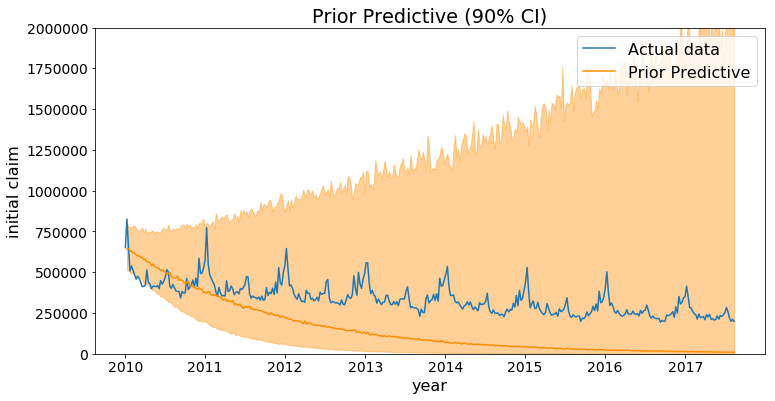

In [109]:
pyro.clear_param_store()

preds = []
for i in range(500):
    preds.append(prob_sgt(N_train-1, 0, y[0]).detach())
preds = torch.stack(preds)
quantiles = [0.1, 0.5, 0.9]
pred_p10, pred_p50, pred_p90 = [preds.kthvalue(int(q*500), dim=0)[0] for q in quantiles]

fig, ax = plt.subplots()
ax.plot(time_range[:N_train], y_train, label='Actual data')
ax.plot(time_range[1:N_train], pred_p50, label='Prior Predictive', color='darkorange')
ax.fill_between(time_range[1:N_train], pred_p10, pred_p90, alpha=0.4, 
                 color='darkorange')
ax.set(title='Prior Predictive (90% CI)', xlabel='year', ylabel='initial claim', ylim=(0, 2e6))
plt.legend();

## Inference Using Stochastic Variational Inference

### MAP Inference Using a Delta Autoguide

To begin with, we will use one of the `autoguide`s from the [pyro.infer.autoguide](http://docs.pyro.ai/en/stable/infer.autoguide.html) module. 
 - The delta autoguide samples from a delta distribution for the latent variables of interest.

### What does the guide program do?

&nbsp;
&nbsp;
&nbsp;

<center>
<img src="static/guide_program.png" width="600" align="center">
</center>

Note the use of another effect handler `poutine.condition` to constrain the site `y` to our training set. The advantage of using `poutine.condition` is that we can use the same model for both training and forecasting!

In [110]:
%%time

from pyro.contrib.autoguide import *

opt = optim.Adam({'lr': 0.05})
pyro.clear_param_store()
pyro.set_rng_seed(2)

model = poutine.condition(prob_sgt, {'y': y_train[1:]})
guide_delta = AutoDelta(model)
guide_delta(N_train-1, x=0, y=y_train[0])
svi = SVI(model, guide_delta, opt, loss=Trace_ELBO())

for i in range(5000):
    loss = svi.step(N_train-1, x=0, y=y_train[0])
    if i % 500 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 1167.0886348713582
ELBO loss: 11.610709840029328
ELBO loss: 11.460727057265277
ELBO loss: 11.356764434570044
ELBO loss: 11.296357550812726
ELBO loss: 11.280233583857665
ELBO loss: 11.278648198848993
ELBO loss: 11.278598637736623
ELBO loss: 11.278593597999171
ELBO loss: 11.278591965910179
ELBO loss: 11.278593223598135
CPU times: user 10.7 s, sys: 70.2 ms, total: 10.8 s
Wall time: 10.8 s


Let us examine the parameters fitted from MAP inference on this model.
 - Note that the runtime has inferred that that `obs_sd`'s support is positive (`HalfNormal` distribution).

In [111]:
pyro.get_param_store().get_state()

{'params': {'auto_slope': tensor(-0.1783, requires_grad=True),
  'auto_obs_sd': tensor(-0.4709, requires_grad=True),
  'auto_seasonality': tensor([ 0.3380,  0.4514,  0.4398,  0.2175,  0.0925,  0.0969,  0.0567, -0.0224,
          -0.0546, -0.0084, -0.0533, -0.1091, -0.1119, -0.1023, -0.0074,  0.0098,
          -0.0394, -0.0564, -0.0885, -0.0901, -0.0943, -0.0772, -0.1052, -0.0227,
          -0.0154, -0.0112,  0.0201,  0.1095,  0.1772, -0.0169, -0.1256, -0.1338,
          -0.1122, -0.1485, -0.1552, -0.1541, -0.2069, -0.1765, -0.1890, -0.2023,
          -0.0680, -0.0344, -0.0720, -0.0484, -0.0047,  0.0629,  0.0272,  0.0742,
           0.1312,  0.2473,  0.1512,  0.2147], requires_grad=True)},
 'constraints': {'auto_slope': Real(),
  'auto_obs_sd': GreaterThan(lower_bound=0.0),
  'auto_seasonality': Real()}}

### Generating Forecasts

 - Model remains the same for both inference and prediction. 
 - To generate forecasts we can simply run the guide to sample latent values from the approximate posterior distribution, and replay these values in the model.

In [112]:
@torch.no_grad()
def get_predictive_samples(model, *args, 
                           guide,
                           num_samples=500, 
                           quantiles=[0.1, 0.5, 0.9]):    
    preds = defaultdict(list)
    for i in range(num_samples):
        guide_trace = poutine.trace(guide).get_trace(*args)
        replay_model = poutine.replay(model, guide_trace)
        model_trace = poutine.trace(replay_model).get_trace(*args)
        preds['slope_sd'].append(model_trace.nodes['slope']['value'].detach())
        preds['slope'].append(model_trace.nodes['slope']['value'].detach())
        preds['obs_sd'].append(model_trace.nodes['obs_sd']['value'].detach())
        preds['y'].append(model_trace.nodes['y']['value'].detach())
    return {k: torch.stack(v) for k, v in preds.items()}

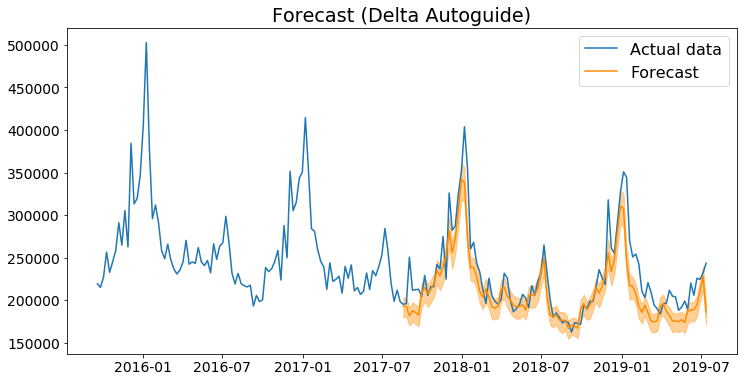

In [113]:
forecast_delta = get_predictive_samples(prob_sgt, N_test, N_train-1, y[N_train-1], 
                                        guide=guide_delta)
p10, p50, p90 = [forecast_delta['y'].kthvalue(int(q * (N_train-1)), dim=0)[0] for q in quantiles]
plt.plot(time_range[-200:], y[-200:], label='Actual data')
plt.plot(time_range[N_train:N_train+N_test], p50, label='Forecast',
         color='darkorange')
plt.fill_between(time_range[398:len(y)], p10, p90, alpha=0.4, 
                 color='darkorange')
plt.title('Forecast (Delta Autoguide)')
plt.legend();

## Variational Inference Using a Normal Autoguide

 - The model and training procedure remains the same as earlier.
 - The Diagonal Normal Autoguide samples from a Normal distribution with diagonal covariance to generate samples from the approximate posterior distribution.

In [115]:
%%time

opt = optim.Adam({'lr': 0.05})
pyro.clear_param_store()
pyro.set_rng_seed(3)

model = poutine.condition(prob_sgt, {'y': y_train[1:]})
guide_diagnormal = AutoDiagonalNormal(model)

svi = SVI(model, guide_diagnormal, opt, loss=Trace_ELBO())

for i in range(15000):
    loss = svi.step(N_train-1, x=0, y=y_train[0])
    if i % 1000 == 0:
        print('ELBO loss: {}'.format(loss / len(y_train)))
print('ELBO loss: {}'.format(loss / len(y_train)))

ELBO loss: 1635.6099374887333
ELBO loss: 13.702471800784968
ELBO loss: 14.182783087893347
ELBO loss: 13.181769165561427
ELBO loss: 13.238506321931006
ELBO loss: 12.757385736134783
ELBO loss: 13.096183725188126
ELBO loss: 12.284013569654531
ELBO loss: 12.14811872717124
ELBO loss: 11.936168397678502
ELBO loss: 11.761296724629162
ELBO loss: 11.752396549561515
ELBO loss: 11.776210038805727
ELBO loss: 11.77866029050482
ELBO loss: 11.799686450005776
ELBO loss: 11.741744031259163
CPU times: user 38.6 s, sys: 203 ms, total: 38.8 s
Wall time: 38.8 s


### Plotting the Model's Forecast

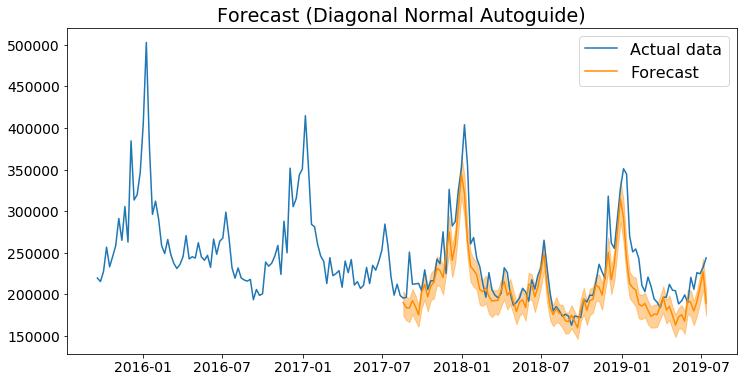

In [116]:
forecast_diagnormal = get_predictive_samples(prob_sgt, N_test, N_train-1, y[N_train-1], 
                                             guide=guide_diagnormal)
p10, p50, p90 = [forecast_diagnormal['y'].kthvalue(int(q * (N_train-1)), dim=0)[0]
                 for q in quantiles]
plt.plot(time_range[-200:], y[-200:], label='Actual data')
plt.plot(time_range[N_train:N_train+N_test], p50, label='Forecast',
         color='darkorange')
plt.fill_between(time_range[398:len(y)], p10, p90, alpha=0.4, 
                 color='darkorange')
plt.title('Forecast (Diagonal Normal Autoguide)')
plt.legend();

### Forecast Using MCMC

 - As mentioned earlier we can use the same model for inference in MCMC.
 - We will use the No-U-Turn sampler which provides an efficient fully automatic algorithm for running HMC.

In [48]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC
from pyro.infer.mcmc.util import predictive
from pyro.ops.stats import hpdi

from torch.distributions.transforms import AffineTransform

In [49]:
model = poutine.condition(prob_sgt, {'y': y_train[1:]})
nuts_kernel = NUTS(model, jit_compile=True, ignore_jit_warnings=True)
mcmc = MCMC(nuts_kernel, num_samples=500, num_chains=4)
mcmc.run(N_train-1, x=0, y=y_train[0])

### Model Summary

In [50]:
print(mcmc.diagnostics()['divergences'])

{'chain 0': [], 'chain 1': [], 'chain 2': [], 'chain 3': []}


In [51]:
mcmc.summary()



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
          slope     -0.18      0.00     -0.18     -0.18     -0.17   2889.31      1.00
         obs_sd      0.67      0.03      0.67      0.63      0.71   1378.74      1.00
 seasonality[0]      0.34      0.01      0.34      0.31      0.36    235.10      1.02
 seasonality[1]      0.45      0.03      0.45      0.41      0.49    580.20      1.01
 seasonality[2]      0.44      0.03      0.44      0.39      0.48    615.89      1.00
 seasonality[3]      0.22      0.03      0.22      0.17      0.26    727.62      1.00
 seasonality[4]      0.09      0.03      0.09      0.05      0.13    807.43      1.00
 seasonality[5]      0.10      0.03      0.10      0.05      0.14    586.60      1.00
 seasonality[6]      0.06      0.03      0.06      0.02      0.10    674.37      1.01
 seasonality[7]     -0.02      0.03     -0.02     -0.06      0.02    716.67      1.01
 seasonality[8]     -0.05      0.03     -0.05     -0

### Plotting Model Forecast

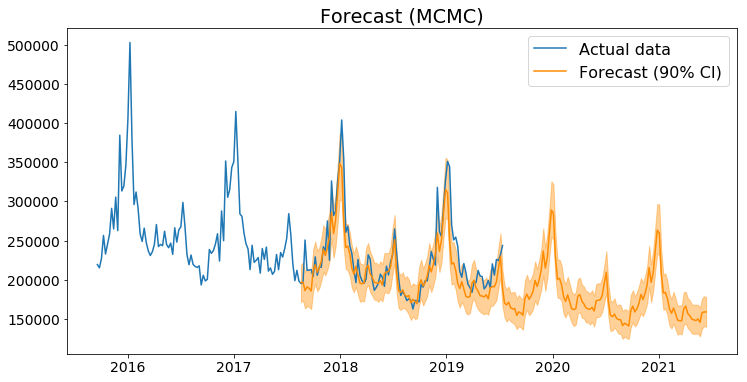

In [52]:
from pyro.util import ignore_experimental_warning

num_steps = N_test + 100
test_range = pd.date_range(start=init_date, freq='7D', periods=len(y) + num_steps)

with ignore_experimental_warning():
    forecast_mcmc = predictive(prob_sgt, mcmc.get_samples(), num_steps, N_train-1, y[N_train-1])
p10, p90 = hpdi(forecast_mcmc['y'], prob=0.9)
p50 = forecast_mcmc['y'].median(dim=0)[0]
plt.plot(time_range[-200:], y[-200:], label='Actual data')
plt.plot(test_range[N_train:N_train+num_steps], p50, label='Forecast (90% CI)',
         color='darkorange')
plt.fill_between(test_range[N_train:N_train+num_steps], p10, p90, alpha=0.4, 
                 color='darkorange')
plt.title('Forecast (MCMC)')
plt.legend();

### Posterior Distribution of Slope for MCMC and SVI

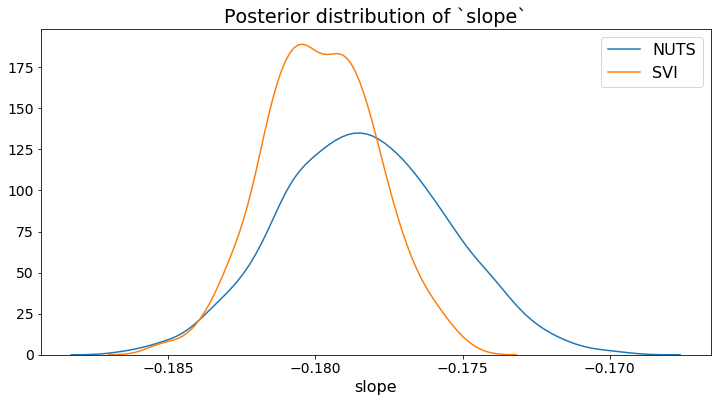

In [57]:
samples = mcmc.get_samples()
fig, ax = plt.subplots()
sns.kdeplot(samples['slope'].cpu().numpy(), ax=ax, label='NUTS')
sns.kdeplot(forecast_diagnormal['slope'].cpu().numpy(), label='SVI')
ax.set(title='Posterior distribution of `slope`', xlabel='slope')
ax.legend();